In [1]:
import re
import pandas as pd
import nltk
import requests
from bs4 import BeautifulSoup
import pickle
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import heapq
from sklearn.metrics.pairwise import cosine_similarity
import folium

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bergi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bergi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data Collection

To perform the steps indicated in:
- 1.1 Get the list of master's degree courses
- 1.2 Crawl master's degree pages

we created a file called `crawler.py` that contains the functions needed to perform the crawling of the pages.
In particular:
- `get_master_urls(pages, url)` returns a list of urls of the master's degree courses
- `save_text(file_path, data)` saves a list of URLs to a text file
- `read_master_urls(path)` reads the list of URLs from a text file
- `download_html_pages(master_urls, output_folder, pages_per_folder=15, start_index=1)` downloads the HTML pages of the master's degree courses starting from the url indicated by the `start_index` parameter and saves them in the `output_folder` folder.

In [459]:
# Import the crawler module
import crawler

# Define the url of the website
url = "https://www.findamasters.com/masters-degrees/msc-degrees/?PG="
master_urls = crawler.get_master_urls(pages=400, url=url)
crawler.save_text("master_urls.txt", master_urls)
master_urls = crawler.read_master_urls("master_urls.txt")
crawler.download_html_pages(master_urls, output_folder="master_pages", start_index=1)

Next, to solve:
- 1.3 Parse downloaded pages

we created a file called `myparser.py` that contains the functions needed to perform the parsing of the pages.
In particular, we are interested in the following information:
- Course Name (to save as courseName): string;
- University (to save as universityName): string;
- Faculty (to save as facultyName): string
- Full or Part Time (to save as isItFullTime): string;
- Short Description (to save as description): string;
- Start Date (to save as startDate): string;
- Fees (to save as fees): string;
- Modality (to save as modality):string;
- Duration (to save as duration):string;
- City (to save as city): string;
- Country (to save as country): string;
- Presence or online modality (to save as administration): string;
- Link to the page (to save as url): string.

The main functions we have created are:
- `process_master_pages(master_pages_folder, output_folder)` that takes as input the folder containing the HTML pages of the master's degree courses and creates a folder `course_info` containing a tsv file for each master's degree course
- `read_tsv(file_path, columns)` that reads all the TSV files in the `course_info` folder and returns a single dataframe

In [5]:
# Import the parser module
import myparser

# Process the master pages
myparser.process_master_pages(master_pages_folder="master_pages", output_folder="course_info")

# Define the column names
columns = ['courseName', 'universityName', 'facultyName', 'isItFullTime', 'description', 'startDate', 
           'fees', 'modality', 'duration', 'city', 'country', 'administration', 'url']
# Read the TSV files and create a dataframe
df = myparser.read_tsv("course_info", columns=columns)
# Save the dataframe as a TSV file
df.to_csv('course_info.tsv', sep='\t', index=False)

Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_140/master_1.html: can only join an iterable
Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_291/master_7.html: can only join an iterable
Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_307/master_3.html: can only join an iterable
Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_363/master_8.html: can only join an iterable
Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_383/master_10.html: can only join an iterable
Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_46/master_4.html: can only join an iterable
Error extracting info: 'NoneType' object is not subscriptable
Error extracting info for page_51/master_5.html: can only join an iterable
Error extracting info: 'NoneType' o

We now take a look at the dataframe to check if it is correct.

In [43]:
# Read the course info data 
df = pd.read_csv('course_info.tsv', sep='\t')
df.head(5)

courseName  \
0           3D Design for Virtual Environments - MSc   
1                       Accounting and Finance - MSc   
2  Accounting, Accountability & Financial Managem...   
3  Accounting, Financial Management and Digital B...   
4                                     Addictions MSc   

                  universityName  \
0  Glasgow Caledonian University   
1            University of Leeds   
2          King’s College London   
3          University of Reading   
4          King’s College London   

                                         facultyName isItFullTime  \
0        School of Engineering and Built Environment    Full time   
1                   Leeds University Business School    Full time   
2                             King’s Business School    Full time   
3                             Henley Business School    Full time   
4  Institute of Psychiatry, Psychology and Neuros...    Full time   

                                         description  startDate  \
0  3D visualisation and animation play a role in ...  September   
1  Businesses and governments rely on sound finan...  September   
2  Our Accounting, Accountability & Financial Man...  September   
3  Embark on a professional accounting career wit...  September   
4  Join us for an online session for prospective ...  September   

                                                fees modality  \
0  Please see the university website for further ...      MSc   
1  UK: £18,000 (Total)International: £34,750 (Total)      MSc   
2  Please see the university website for further ...      MSc   
3  Please see the university website for further ...      MSc   
4  Please see the university website for further ...      MSc   

           duration     city         country administration  \
0  1 year full-time  Glasgow  United Kingdom      On Campus   
1  1 year full time    Leeds  United Kingdom      On Campus   
2         1 year FT   London  United Kingdom      On Campus   
3  1 year full time  Reading  United Kingdom      On Campus   
4       One year FT   London  United Kingdom      On Campus   

                                                 url  
0  https://www.findamasters.com/masters-degrees/c...  
1  https://www.findamasters.com/masters-degrees/c...  
2  https://www.findamasters.com/masters-degrees/c...  
3  https://www.findamasters.com/masters-degrees/c...  
4  https://www.findamasters.com/masters-degrees/c...

In [44]:
df.shape

(5985, 13)

We can see that 15 master's degree courses are missing. This is because, at the time of the scraping, some of the pages of these master's degree courses were not available. Indeed, the error code we encountered was 500 (Internal Server Error).

# 2. Search Engine

## 2.0 Preprocessing

### Preprocessing the text
First we define a function to pre-process all the information collected for each MSc by:

- Converting to lowercase
- Tokenizing
- Removing stopwords
- Removing punctuation
- Stemming

Using the 'nltk' library, we can easily perform all these steps.

Moreover, all the functions we created to preprocess the text are contained in a separate file called `prepro.py`.

In [45]:
# Import the prepro module that contains the functions for text preprocessing
import prepro

# Save the cleaned description in a new column
df['cleaned_descr'] = df.description.apply(prepro.preprocess_text)
df.head(5)

courseName  \
0           3D Design for Virtual Environments - MSc   
1                       Accounting and Finance - MSc   
2  Accounting, Accountability & Financial Managem...   
3  Accounting, Financial Management and Digital B...   
4                                     Addictions MSc   

                  universityName  \
0  Glasgow Caledonian University   
1            University of Leeds   
2          King’s College London   
3          University of Reading   
4          King’s College London   

                                         facultyName isItFullTime  \
0        School of Engineering and Built Environment    Full time   
1                   Leeds University Business School    Full time   
2                             King’s Business School    Full time   
3                             Henley Business School    Full time   
4  Institute of Psychiatry, Psychology and Neuros...    Full time   

                                         description  startDate  \
0  3D visualisation and animation play a role in ...  September   
1  Businesses and governments rely on sound finan...  September   
2  Our Accounting, Accountability & Financial Man...  September   
3  Embark on a professional accounting career wit...  September   
4  Join us for an online session for prospective ...  September   

                                                fees modality  \
0  Please see the university website for further ...      MSc   
1  UK: £18,000 (Total)International: £34,750 (Total)      MSc   
2  Please see the university website for further ...      MSc   
3  Please see the university website for further ...      MSc   
4  Please see the university website for further ...      MSc   

           duration     city         country administration  \
0  1 year full-time  Glasgow  United Kingdom      On Campus   
1  1 year full time    Leeds  United Kingdom      On Campus   
2         1 year FT   London  United Kingdom      On Campus   
3  1 year full time  Reading  United Kingdom      On Campus   
4       One year FT   London  United Kingdom      On Campus   

                                                 url  \
0  https://www.findamasters.com/masters-degrees/c...   
1  https://www.findamasters.com/masters-degrees/c...   
2  https://www.findamasters.com/masters-degrees/c...   
3  https://www.findamasters.com/masters-degrees/c...   
4  https://www.findamasters.com/masters-degrees/c...   

                                       cleaned_descr  
0  3d visualis anim play role mani area popular m...  
1  busi govern reli sound financi knowledg underp...  
2  account account financi manag msc cours provid...  
3  embark profession account career academ msc pr...  
4  join us onlin session prospect student find ms...

### Preprocessing the fees column

Next, we use a function from the `prepro` module to pre-process the fees column by specyfing different queries to extract the information we need using regular expressions.

We also want to convert the currencies into dollars. Instead of using an API, we directly scrape the same website from which one of the main APIs takes its information. In particular, we extract the conversion rates and then we convert the fees into dollars.
We do this becuase many API and libraries we found do not seem too reliable and have some issues (e.g. function properly only on working days).

To this end, in the `prepro` module we defined a function called `exchange_rates` that takes as input the url of the website from which we want to extract the conversion rates and returns a dictionary containing the conversion rates.


In [96]:
# Get exchange rates
exchange_rates = prepro.get_exchange_rates()

# Apply the preprocess_fees function to the 'fees' column
df[['fees_$', 'currency']] = df['fees'].apply(lambda x: pd.Series(prepro.preprocess_fees(x, exchange_rates)))
df[['fees', 'fees_$', 'currency']].head(5)

fees    fees_$ currency
0  Please see the university website for further ...      0.00         
1  UK: £18,000 (Total)International: £34,750 (Total)  43692.67        £
2  Please see the university website for further ...      0.00         
3  Please see the university website for further ...      0.00         
4  Please see the university website for further ...      0.00

We now check to see how many fees we have converted into dollars.

In [47]:
print('Converted:', len(df[df['fees_$'] != 0]))
print('No info:', len(df[df['fees'] =='Please see the university website for further information on fees for this course.']))

Converted: 1418
No info: 3417


We can see that the majority of the courses don't have infos about the fees. Many courses, moreover, use different sentences to tell the user to look on their website for more information about the fees, thus the number of courses with no info on fees is even higher than the one shown above.

For those that specify the fees, the function we implemented seems to be able to convert most of them into dollars.

## 2.1 Conjunctive query

### 2.1.1 Create your index

Before builidng the index, we want to create a file named **vocabulary** that maps each word to an integer (*term_id*). For this purpose, we are going to define a function that takes as input the list of all the pre-processed words in the corpus and returns a dictionary that maps each word to an integer. Then, we are going to convert the *vocabulary* dictionary into a dataframe and save it as a `pkl` file because doing so we will not lose the mapping between the words and the integers.

In [48]:
# Function to create a vocabulary from a list of tokens
def create_vocabulary(tokens):
    # Initialize an empty dictionary
    voc = {}
    i = 0
    # Loop over the tokens
    for token in tokens:
        for t in token:
            # Add the token to the dictionary if it is not there
            if t not in voc:
                voc[t] = i
                i += 1
    return voc

# Create a list of tokens to pass to the function
tk = [df['cleaned_descr'][i].split() for i in range(len(df['cleaned_descr']))]

# Create the vocabulary
vocabulary = create_vocabulary(tk)

Let's check if the vocabulary seems correct.

In [49]:
print(vocabulary)

{'3d': 0, 'visualis': 1, 'anim': 2, 'play': 3, 'role': 4, 'mani': 5, 'area': 6, 'popular': 7, 'media': 8, 'keep': 9, 'grow': 10, 'digit': 11, 'provid': 12, 'special': 13, 'effect': 14, '21st': 15, 'centuri': 16, 'favourit': 17, 'film': 18, 'televis': 19, 'show': 20, 'design': 21, 'also': 22, 'essenti': 23, 'everyday': 24, 'work': 25, 'everyth': 26, 'comput': 27, 'game': 28, 'develop': 29, 'onlin': 30, 'virtual': 31, 'world': 32, 'industri': 33, 'market': 34, 'product': 35, 'programm': 36, 'environ': 37, 'help': 38, 'skill': 39, 'thrive': 40, 'success': 41, 'career': 42, 'visual': 43, 'practic': 44, 'orient': 45, 'toward': 46, 'current': 47, 'need': 48, 'technolog': 49, 'prior': 50, 'knowledg': 51, 'requir': 52, 'busi': 53, 'govern': 54, 'reli': 55, 'sound': 56, 'financi': 57, 'underpin': 58, 'strategi': 59, 'cours': 60, 'profession': 61, 'advanc': 62, 'modern': 63, 'theori': 64, 'account': 65, 'control': 66, 'well': 67, 'understand': 68, 'organis': 69, 'cover': 70, 'fundament': 71, 'to

In [50]:
# Save the vocabulary to a pkl file
with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)

If needed, we can load the vocabulary from the file like this:

```
with open('vocabulary.pkl', 'rb') as f:
        vocabulary = pickle.load(f)
```

Now we can build the inverted index. It is a dictionary that maps each term_id to a list of documents that contain that term. In other words, we want a dictionary like this:

```
{  
term_id_1:[document_1, document_2, document_4],
term_id_2:[document_1, document_3, document_5, document_6],
...}
    
``` 


In [51]:
# Function to create an inverted index from a vocabulary and a list of tokens
def create_inverted_indx(vocabulary, tokens):
    # Initialize an dicitonary with as keys the term ids and as values empty sets
    inverted_index = {term_id: set() for term_id in vocabulary.values()}
    
    # Loop over the tokens
    for i, l in enumerate(tokens):
        for token in l:
            # Get the term id from the vocabulary
            term_id = vocabulary.get(token)
            # Add the document id to the set of the inverted index
            if term_id is not None:
                inverted_index[term_id].add(i)
                
    return inverted_index

In [52]:
# Create the inverted index using the function above 
inverted_indx = create_inverted_indx(vocabulary, tk)
print(inverted_indx)

{0: {0, 4001, 4834, 4835, 1062, 3174, 5326, 2799, 1490, 1492, 404, 1493, 2710, 3928, 4765}, 1: {0, 4481, 1285, 5775, 274, 275, 5920, 5921, 5924, 5541, 5161, 1326, 5759, 1328, 5173, 5175, 4411, 2756, 1349, 2758, 713, 1353, 3020, 1229, 4556, 222, 4063, 2785, 4065, 1252, 997, 1254, 1255, 1257, 237, 878, 1261, 1262, 2679, 2558, 1279}, 2: {0, 7, 2568, 5662, 1063, 554, 2603, 1585, 2613, 55, 5691, 5695, 5697, 5698, 5702, 5710, 3153, 1620, 3156, 5717, 3160, 120, 1656, 3194, 2684, 1665, 1672, 139, 140, 2710, 1692, 1693, 4773, 186, 3260, 2252, 2261, 2289, 2292, 757, 5902, 2322, 4883, 789, 5418, 5932, 3889, 3890, 5943, 4922, 3397, 5980, 4962, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 4469, 3455, 5518, 3488, 3489, 5038, 4023, 5577, 5102, 1016}, 3: {0, 2052, 3078, 3079, 2568, 522, 2572, 14, 2065, 2578, 5142, 1565, 4641, 1575, 1577, 2098, 5175, 5709, 5710, 3153, 5714, 3667, 4691, 5214, 5215, 97, 3683, 1636, 2671, 115, 5235, 1141, 120, 1145, 1146, 1147,

In [53]:
# Save the inverted index to a pkl file
with open('inverted_indx.pkl', 'wb') as f:
    pickle.dump(inverted_indx, f)

### 2.1.2 Execute the query

It is time to create the Search Engine. 
Given a query input by the user, this search engine is supposed to return a list of documents. In particular, since we are dealing with **conjunctive queries**, we want to **return only the documents that contain all the words in the query**.

First, we define a function that takes as input a query and returns a list of the pre-processed words in the query. Then, we define a function that takes as input the list of pre-processed words in the query and returns a list of the documents that contain all the words in the query.

In [54]:
# Function to get the tokens from the input
def get_tokens(description):
    # Convert to lowercase
    description = description.lower()
    # Tokenize
    tokens = nltk.word_tokenize(description)
    # Exclude the stopwords and punctuation
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Stem the remaining words
    stemmer = nltk.PorterStemmer()
    tokens = set(stemmer.stem(word) for word in tokens)
    
    return tokens

# Function to execute a query and return a set of document IDs
def execute_query(query, vocabulary, inverted_index):
    # Tokenize query
    tokens = get_tokens(query)
    # Get term IDs
    query_terms = [vocabulary.get(token) for token in tokens]
    
    # If a term is not in the vocabulary, it means no document will contain it, thus return empty set
    if None in query_terms:
        print('One of the query terms is not in the vocabulary')
        return set()
    
    if query_terms:
        # Get documents containing the query terms
        documents = [inverted_index[term] for term in query_terms]
        
        # Return the intersection of the documents (i.e. the indices of the documents containing all the query terms)
        return set.intersection(*documents)
    else:
        return set()

In [55]:
# Execute query and get the indexes of the documents
indexes = execute_query('advanced knowledge', vocabulary, inverted_indx)
# Locate the documents in the dataframe and subselect the columns of interest
query_res = df.loc[list(indexes), ['courseName', 'universityName', 'description', 'url']]
query_res.head()

courseName  \
2048  Engineering Materials (Advanced Mechanical Eng...   
1                          Accounting and Finance - MSc   
4099                         MA/MSc - Design Innovation   
4                                        Addictions MSc   
10                            Analytical Toxicology MSc   

                 universityName  \
2048  University of Southampton   
1           University of Leeds   
4099     De Montfort University   
4         King’s College London   
10        King’s College London   

                                            description  \
2048  Develop specialist knowledge of mechanical eng...   
1     Businesses and governments rely on sound finan...   
4099  With a flexible curriculum to accommodate your...   
4     Join us for an online session for prospective ...   
10    The Analytical Toxicology MSc is a unique stud...   

                                                    url  
2048  https://www.findamasters.com/masters-degrees/c...  
1     https://www.findamasters.com/masters-degrees/c...  
4099  https://www.findamasters.com/masters-degrees/c...  
4     https://www.findamasters.com/masters-degrees/c...  
10    https://www.findamasters.com/masters-degrees/c...

## 2.2 Conjuctive Query and Ranking Score

For the second search engine, given a query, we want to get only the top-k documents related to the query. 
In particular, our search engine is supposed to:
- Find all the documents that contain all the words in the query.
- Sort them by their similarity with the query.
- Return in output k documents, or all the documents with non-zero similarity with the query when the results are less than k (using an Heap data structure to mantain the top-k documents).

### 2.2.1 Build Inverted TfIdf Index

We need to build a second Inverted Index. This time, for each word, we want the list of documents in which it is contained and the relative tfIdf score. In other words, we want a dictionary like this:
```
{
term_id_1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
term_id_2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
...}
```

To do this we create a function that takes as input the vocabulary, the inverted index and the tokens and returns the new inverted index with the tfIdf scores. Using the previously bulit `inverted_indx` and `vocabulary` wil allow us to save time and memory.

The formula we are using to compute the tfIdf score is the following:

$$tfIdf_{term,document} = tf_{term,document} * idf_{term}$$

where:

$$tf_{term,document} = \frac{c_{term,document}}{n_{document}}$$

$$idf_{term} = log(\frac{N}{df_{term}})$$

where $c_{term,document}$ is the count of the term in the document, $n_{document}$ is the total number of terms in the document, $N$ is the number of documents in the corpus and $df_{term}$ is the number of documents in the collection in which the term appears.

In [56]:
# Function to compute the tf-idf of a term in a document
def inverted_index_tfidf(vocabulary, inverted_indx, tokens):
    
    # Initialize a dictionary with as keys the term ids and as values empty sets
    inverted_index1 = {term_id: set() for term_id in vocabulary.values()}
    
    # Loop over the tokens
    for i, l in enumerate(tokens):
        for token in l:
            # Get the term id from the vocabulary
            term_id = vocabulary.get(token)
            if term_id is not None:
                # Compute the frequency of the term in the document
                tf = l.count(token)/len(l)
                # Compute the idf of the term
                idf = math.log((len(tokens))/(len(inverted_indx[term_id]) + 1))
                # Add the document id and the tf-idf to the set of the inverted index
                inverted_index1[term_id].add((i, tf*idf))
                
    return inverted_index1

# Create the inverted index using the function above
inverted_index_2 = inverted_index_tfidf(vocabulary, inverted_indx, tk)
inverted_index_2

{0: {(0, 0.3484954644560172),
  (404, 0.10579326599557665),
  (1062, 0.12605155097345302),
  (1490, 0.10393724378512793),
  (1492, 0.08976398326897414),
  (1493, 0.08842422232466109),
  (2710, 0.09256910774612957),
  (2799, 0.18513821549225914),
  (3174, 0.10214522234055677),
  (3928, 0.1645673026597859),
  (4001, 0.17952796653794828),
  (4765, 0.09712168681561135),
  (4834, 0.09874038159587155),
  (4835, 0.11178156407079796),
  (5326, 0.2777073232383887)},
 1: {(0, 0.07293149999571626),
  (222, 0.08550589654670182),
  (237, 0.10781178260236315),
  (274, 0.09183966666127232),
  (275, 0.13403627026239745),
  (713, 0.10781178260236315),
  (878, 0.08855967856622687),
  (997, 0.08265569999514509),
  (1229, 0.07871971428109056),
  (1252, 0.09357249056054161),
  (1254, 0.07871971428109056),
  (1255, 0.13050899999233434),
  (1257, 0.0708477428529815),
  (1261, 0.08130068851981484),
  (1262, 0.08700599999488956),
  (1279, 0.19448399998857668),
  (1285, 0.12881407791451183),
  (1326, 0.12095956

We are also going to compute the *tf-idf* score using the pre-built function in the `sklearn` library, since its output can be more easily transformed into a dataframe with the tf-idf scores for each term in each document which is more convenient for us to use when computing the cosine similarity and also because it uses a slightly different formula for the tf-idf score, which we trust to be more reliable and accurate.

In [57]:
# Use the TfidfVectorizer to compute the tf-idf of the terms in the cleaned_description column
tfidf = TfidfVectorizer(lowercase=False)
results = tfidf.fit_transform(df.cleaned_descr)
# Convert the results to a dense matrix and create a dataframe
result_dense = results.todense()
tfidf_data = pd.DataFrame(result_dense.tolist(), index=df.index, columns=tfidf.get_feature_names_out())
tfidf_data.head()

10  100  1000  104kmedian  10global   11  11th        12  120  125kmedian  \
0  0.0  0.0   0.0         0.0       0.0  0.0   0.0  0.000000  0.0         0.0   
1  0.0  0.0   0.0         0.0       0.0  0.0   0.0  0.000000  0.0         0.0   
2  0.0  0.0   0.0         0.0       0.0  0.0   0.0  0.000000  0.0         0.0   
3  0.0  0.0   0.0         0.0       0.0  0.0   0.0  0.000000  0.0         0.0   
4  0.0  0.0   0.0         0.0       0.0  0.0   0.0  0.128324  0.0         0.0   

   ...  zoonosi  zoonot   zu  zudem  zum  zur  zurich  zwingen  école  \
0  ...      0.0     0.0  0.0    0.0  0.0  0.0     0.0      0.0    0.0   
1  ...      0.0     0.0  0.0    0.0  0.0  0.0     0.0      0.0    0.0   
2  ...      0.0     0.0  0.0    0.0  0.0  0.0     0.0      0.0    0.0   
3  ...      0.0     0.0  0.0    0.0  0.0  0.0     0.0      0.0    0.0   
4  ...      0.0     0.0  0.0    0.0  0.0  0.0     0.0      0.0    0.0   

   ísafjörður  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 9569 columns]

### 2.2.2 Execute the query

Finally, given a query defined by the user, we get the proper masters' descriptions (i.e., those containing all the query's words) and sort them according to their similarity to the query using, as the scoring function, the Cosine Similarity concerning the tfIdf representations of the descriptions which we have computed in the previous step. 

Moreover, to mantain the top-k documents we use an Heap data structure.

In [58]:
# Function to execute a query and return a set of k document IDs ranked by cosine similarity
def execute_query2(query, tfidf_data, dataframe, inverted_indx, k=5):
    # Leverage previous function to get the indexes of the documents
    indexes = execute_query(query, vocabulary, inverted_indx)
    
    # Keep the relevant documents and columns
    query_res1 = dataframe.loc[list(indexes), ['courseName', 'universityName', 'description', 'url']]
    
    # Keep the relevant tfidf data
    relevant_docs = tfidf_data.iloc[list(indexes)]
    
    # Convert the query to tf-idf representation after tokenization
    query_tfidf = tfidf.transform(get_tokens(query))

    try:
        # Calculate cosine similarity between the query and relevant documents
        cos_sim = cosine_similarity(query_tfidf, relevant_docs)[0]

        # Create a heap to maintain the top-k documents based on similarity
        heap = []
        # Loop over the cosine similarity scores
        for doc_index, similarity_score in enumerate(cos_sim):
            # Push the document index and similarity score to the heap
            heapq.heappush(heap, (similarity_score, doc_index))
            # If the heap size exceeds k, remove the smallest element
            if len(heap) > k:
                heapq.heappop(heap)

        # Get the top-k documents from the heap
        top_k = heapq.nlargest(k, heap)

        # Retrieve the corresponding rows and scores from the heap
        result_rows = [query_res1.iloc[doc_index] for _, doc_index in top_k]
        similarity_scores = [similarity_score for similarity_score, _ in top_k]

        return result_rows, similarity_scores
    
    except ValueError:
        # If the query is not relevant to any document, return empty lists
        print('No relevant documents found. Check your query.')
        return [], []

In [59]:
# Example usage
query_res2, similarity = execute_query2('advanced knowledge', tfidf_data, df, inverted_indx, k=10)
# Convert the list of dictionaries to a DataFrame
query_res2_df = pd.DataFrame(query_res2)
query_res2_df['Similarity'] = similarity
query_res2_df.head(5)

courseName  \
5216       Advanced Healthcare Practice - MSc   
5117           Advanced Clinical Practice MSc   
5187                   Advanced Computing MSc   
5376                 Advancing Practice - MSc   
5145  Advanced Computer Science - MSc/PgD/PgC   

                       universityName  \
5216               Cardiff University   
5117          University of Greenwich   
5187            King’s College London   
5376        University of Northampton   
5145  Cardiff Metropolitan University   

                                            description  \
5216  Why study this courseOur MSc Advanced Healthca...   
5117  Learn essential strategies and prepare for lea...   
5187  Our Advanced Computing MSc provides knowledge ...   
5376  Our MSc Advancing Practice awards support the ...   
5145  This Master's degree in Advanced Computer Scie...   

                                                    url  Similarity  
5216  https://www.findamasters.com/masters-degrees/c...    0.444869  
5117  https://www.findamasters.com/masters-degrees/c...    0.440567  
5187  https://www.findamasters.com/masters-degrees/c...    0.412553  
5376  https://www.findamasters.com/masters-degrees/c...    0.398593  
5145  https://www.findamasters.com/masters-degrees/c...    0.382877

# 3. Define a new score!

In [79]:
# Function to calculate a new relevance score based on query terms
def new_score(row, query_tokens):
    score = 0
    # Score based on the length of cleaned description
    score += len(row['cleaned_descr'].split())
    
    stemmer = nltk.PorterStemmer()
    # Keywords associated with MSc degrees
    msc_keywords = ['master', 'msc', 'graduate', 'postgraduate', 'job', 'career', 'profession', 'research', 'internship',
                    'thesis', 'best', 'top', 'rank', 'ranked', 'rankings', 'ranking', 'university', 'universities']
    msc_keywords = [stemmer.stem(keyword) for keyword in msc_keywords]
    # Increment score if MSc keywords are present in the query
    for keyword in msc_keywords:
        if keyword in query_tokens:
            score += row['cleaned_descr'].lower().count(keyword)

    # Normalize the score to a scale between 0 and 1
    score_normalized = score / 100
    
    return score_normalized

# Function to execute a query and return relevant documents with new scores
def execute_query_newscore(query, dataframe, inverted_index, k=5, cols=None):
    indexes = execute_query(query, vocabulary, inverted_index)
    
    # Default columns if not provided
    if cols is None:
        cols = ['courseName', 'universityName', 'cleaned_descr', 'url', 'fees_$', 'city', 'country']

    query_res1 = dataframe.loc[list(indexes), cols]
    relevant_docs = tfidf_data.iloc[list(indexes)]
    query_tokens = get_tokens(query)
    
    # Calculate and add new similarity scores to the DataFrame
    query_res1['New_Similarity'] = query_res1.apply(lambda dataframe: new_score(dataframe, query_tokens), axis=1)

    heap = []

    for _, r in query_res1.iterrows():
        row_values = [r[col] for col in cols + ['New_Similarity']]
        heapq.heappush(heap, tuple(row_values))

        if len(heap) > k:
            heapq.heappop(heap)

    top_k = heapq.nlargest(k, heap)
    cols = cols + ['New_Similarity']
    query_res_newscore_df = pd.DataFrame(top_k, columns=cols).sort_values(by='New_Similarity', ascending=False)
    return query_res_newscore_df


# Example usage
query_res_newscore = execute_query_newscore('advanced knowledge', df, inverted_indx, k=5)
query_res_newscore

courseName               universityName  \
0                      Stroke Medicine MSc         Learna | Diploma MSc   
4                     Masters in Economics         University of Lisbon   
2  Materials Science and Engineering - MSc          University of Leeds   
1                            Physics - MSc          University of Leeds   
3        Masters in Hospitality Management  Ecole hotelière de Lausanne   

                                       cleaned_descr  \
0  postgradu train stroke care limit worldwid ina...   
4  objectivesth msc econom aim provid advanc know...   
2  materi scienc forefront provid innov solut man...   
1  studi physic msc leed give chanc advanc knowle...   
3  master hospit manag best posit kickstart caree...   

                                                 url        fees_$      city  \
0  https://www.findamasters.com/masters-degrees/c...   9807.274989   Cardiff   
4  https://www.findamasters.com/masters-degrees/c...   7641.200000    Lisbon   
2  https://www.findamasters.com/masters-degrees/c...  38977.631367     Leeds   
1  https://www.findamasters.com/masters-degrees/c...  38977.631367     Leeds   
3  https://www.findamasters.com/masters-degrees/c...      0.000000  Lausanne   

          country  New_Similarity  
0  United Kingdom            0.75  
4        Portugal            0.59  
2  United Kingdom            0.51  
1  United Kingdom            0.43  
3     Switzerland            0.34

This code changes document retrieval incorporating a brand new relevance rating primarily based on what we thought could be relevant keywords like for example "job", "top", "research" which should highlight the quality or research/job oriented focus of a program. The `new_score` function calculates the rating, considering these keywords. The `execute_query_newscore` function executes a query, retrieves relevant files, and provides the new similarity scores.

### Are the results you obtain better than with the previous scoring function? Explain and compare results.

The following code compares the maximum similarity scores achieved by the old and new scoring functions. It then determines which scoring function yields better results based on the maximum scores. The results are printed to provide insights into the effectiveness of the new scoring function.

In [64]:
# Get the maximum similarity score from the old scoring function
max_similarity_old = query_res2_df['Similarity'].max()

# Get the maximum score from the new scoring function
max_similarity_new = query_res_newscore['New_Similarity'].max()

# Print the maximum scores for comparison
print("Maximum Similarity Score (Cosine Scoring Function):", max_similarity_old)
print("Maximum New Score (New Scoring Function wrt description):", max_similarity_new)

# Compare the results of the two scoring functions and print the conclusion
if max_similarity_new > max_similarity_old:
    print("Results of new scoring function are better.")
elif max_similarity_new < max_similarity_old:
    print("Results of previous scoring function are better.")
else:
    print("Results of both scoring functions are comparable.")

Maximum Similarity Score (Cosine Scoring Function): 0.444869196810096
Maximum New Score (New Scoring Function wrt description): 0.75
Results of new scoring function are better.


It is difficult to say which scoring function is better. The new scoring function seems to be better for some queries, while the old scoring function seems to be better for others. The new scoring function seems to be better for queries that are more general, while the old scoring function seems to be better for queries that are more specific. The results of the new scoring function are highly dependent on the choice of keywords. The keywords we chose are for sure not perfect, but they seem to be a good starting point. We could improve the new scoring function by adding more keywords and/or by choosing better keywords.

# 4. Visualizing the most relevant MSc degrees

This function, `get_coordinates_by_name`, takes a list of university names as input and returns a dictionary containing the university names as keys and their corresponding geographical coordinates (latitude and longitude) as values.
It utilizes the geolocator to fetch the coordinates for each university name.

In [67]:
def get_coordinates_by_name(university_name):
    # Initialize an empty dictionary to store coordinates
    d = {}
    
    # Loop through each university name in the provided list
    for i,j in university_name:
        # Use geolocator to get the location coordinates of the university
        location = geolocator.geocode(i)
        
        # Check if the location is found
        if location:
            # If found, store the latitude and longitude in the dictionary
            d[i] = (location.latitude, location.longitude)
        else:
            # If not found, store None for both latitude and longitude
            d[i] = (None, None)
    
    # Return the dictionary containing university names and their coordinates
    return d

In [82]:
# Import the Nominatim geocoder from the geopy library
from geopy.geocoders import Nominatim

# Initialize a Nominatim geolocator with a user agent and timeout
geolocator = Nominatim(user_agent="my-application123", timeout=3)

# Function to add latitude and longitude columns to a DataFrame based on university names
def geo(unique_universities, query):
    # Get coordinates for unique university names
    locs = get_coordinates_by_name(unique_universities)

    # Create a DataFrame from the coordinates dictionary
    df_locs = pd.DataFrame.from_dict(locs, orient='index', columns=['Latitude', 'Longitude'])
    df_locs.reset_index(inplace=True)
    df_locs.rename(columns={'index': 'universityName'}, inplace=True)
    
    # Merge the original DataFrame with the new coordinates DataFrame based on universityName
    df = pd.merge(query, df_locs, on='universityName', how='left')
    df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
    
    # Return the merged DataFrame
    return df

This code uses the `geopy` library to retrieve geographic coordinates (latitude, longitude) for a unique list of university names. The resulting coordinates are then combined into a DataFrame with the 'Latitude' and 'Longitude' columns. The Act supports a name-based geographic map of universities.

In [118]:
# Define a function to create a Folium Map and add markers for each location
def maps(df, cols=None):
    # Create a Folium Map centered on Italy's coordinates
    m = folium.Map(location=[42.5, 12.5], zoom_start=2)

    # Dictionary to keep track of coordinates and their associated universities
    coordinates_dict = {}

    # Iterate through the DataFrame to add markers for each location
    for index, row in df.iterrows():
        # Extract values for the specified columns
        values = [row[col] for col in cols]
        # Create a popup string with the extracted values and HTML formatting
        popup = "<h4 style='color:red;'>University:</h4>"
        popup += f"<p><strong>{row['universityName']}</strong></p>"
        popup += "<p> - ".join(map(str, values))

        # Check if the coordinates already exist in the dictionary
        if (row['Latitude'], row['Longitude']) in coordinates_dict:
            # If the coordinates exist, update the popup string to include both universities
            popup = coordinates_dict[(row['Latitude'], row['Longitude'])] + "<hr>" + popup

        # Add a CircleMarker for each location
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=folium.Popup(popup, max_width=300)  # Set max_width to limit the popup width
        ).add_to(m)

        # Update the coordinates dictionary with the universities at the same coordinates
        coordinates_dict[(row['Latitude'], row['Longitude'])] = popup

    # Save the map as an HTML file
    m.save('map.html')

    # Return the map and DataFrame
    return m, df


This function creates an interactive Folium map with labels for geographic locations based on the latitude and longitude information stored in the DataFrame. The pop-up information for each symbol is customized using the specified characters from the DataFrame. The resulting map is saved as an HTML file.

In [120]:
# Execute the query from Q3
query_news = execute_query_newscore('advanced knowledge', df, inverted_indx, k=15)

# Get unique university names from the 'universityName' column in the DataFrame
unique_universities = query_news['universityName'].unique()

# Apply the geo function to get the coordinates of the universities
gdf = geo(unique_universities, query_news)

# Specify the columns to display in the popup
popup_cols = ['courseName', 'city']

# Create the map and DataFrame
m, newdf = maps(gdf, popup_cols)
m

### Visualization including fees

In [121]:
# Add the fees column to the list of columns to display
popup_cols += ['fees_$']
m, newdf = maps(gdf, popup_cols)
m

We are now interested in computing the distance of the univeristis from the center of Italy to know how much a student of Sapienza would have to travel to reach the university of his/her choice. 

In [123]:
from math import radians, sin, cos, sqrt, atan2

# Functionn to calculate the distance between two coordinates
def calculate_distance(lat1, lon1, lat2, lon2):
    # The radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Calculate the differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula to calculate the distance
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance

# We assume we want to know the distance of the universities from the center of Italy
# We can thus use the coordinates of Italy's center as the target coordinates
target_lat = 42.5
target_lon = 12.5

# Create a new DataFrame to store the information
result_df = pd.DataFrame(columns=['universityName', 'city', 'country', 'distance', 'fees_$'])

# Create an empty list to store dictionaries
result_data = []

# Iterate through the DataFrame to add data for each location
for index, row in newdf.iterrows():
    # Assuming you have a function calculate_distance(lat1, lon1, lat2, lon2) to calculate distance
    distance = calculate_distance(row['Latitude'], row['Longitude'], target_lat, target_lon)

    # Create a dictionary for the current row
    data_dict = {
        'universityName': row['universityName'],
        'city': row['city'],
        'country': row['country'],
        'distance': distance,
        'fees_$': row['fees_$']
    }

    # Append the dictionary to the list
    result_data.append(data_dict)

# Create a DataFrame from the list of dictionaries
result_df = pd.DataFrame(result_data)

# Display the result_df
result_df

universityName             city  \
0   The Hong Kong University of Science and Techno...  Clear Water Bay   
1   The Hong Kong University of Science and Techno...  Clear Water Bay   
2                                University of Lisbon           Lisbon   
3                            Johns Hopkins University        Baltimore   
4                   Atlantic Technological University           Galway   
5                                 University of Leeds            Leeds   
6                                 University of Leeds            Leeds   
7                            Johns Hopkins University        Baltimore   
8   The Hong Kong University of Science and Techno...  Clear Water Bay   
9                 London School of Business & Finance           London   
10                        Ecole hotelière de Lausanne         Lausanne   
11                  Atlantic Technological University           Galway   
12                  University of Southern California      Los Angeles   

           country      distance    fees_$  
0        Hong Kong   9256.022664  89000.00  
1        Hong Kong   9256.022664  23100.00  
2         Portugal   1869.055308   7641.20  
3              USA   7126.745861      0.00  
4          Ireland   2036.866142      0.00  
5   United Kingdom   1627.326310  38977.63  
6   United Kingdom   1627.326310  38977.63  
7              USA   7126.745861      0.00  
8        Hong Kong   9256.022664  89000.00  
9   United Kingdom   1381.795325  18000.00  
10     Switzerland    645.178925      0.00  
11         Ireland   2036.866142      0.00  
12             USA  10142.456209      0.00

# 5. BONUS: More complex search engine

We are going to implement a more complex search engine that is able to handle also the following cases:
- Give the possibility to specify queries for the following features (the user should have the option to issue none or all of them):
    -   courseName
    -   universityName
    -   universityCity
- Specify a range for the fees to retrieve only MSc whose taxation is in that range.
- Specify a list of countries which the search engine should only return the courses taking place in city within those countries.
- Filter based on the courses that have already started.
- Filter based on the presence of online modality.

We start by building inverted indexes for each of the features we want to be able to query. In particular, we are going to build an inverted index for each of the following features:
- courseName
- universityName
- universityCity

In [153]:
# Preprocess the courseName column
df['cleaned_cName'] = df.courseName.apply(prepro.preprocess_text)

# Create a list of tokens to pass to the function
tk_cName = [df['cleaned_cName'][i].split() for i in range(len(df['cleaned_cName']))]

# Create the vocabulary
vocabulary_cName = create_vocabulary(tk_cName)

# Create the inverted index
inverted_indx_cName = create_inverted_indx(vocabulary_cName, tk_cName)

In [154]:
# Preprocess the universityName column
df['cleaned_uName'] = df.universityName.apply(prepro.preprocess_text)

# Create a list of tokens to pass to the function
tk_uName = [df['cleaned_uName'][i].split() for i in range(len(df['cleaned_uName']))]

# Create the vocabulary
vocabulary_uName = create_vocabulary(tk_uName)

# Create the inverted index
inverted_indx_uName = create_inverted_indx(vocabulary_uName, tk_uName)

In [366]:
# Get the cities
tk_city = [df['city'][i].split() for i in range(len(df['city']))]

# Create the vocabulary
vocabulary_city = create_vocabulary(tk_city)

# Create the inverted index
inverted_indx_city = create_inverted_indx(vocabulary_city, tk_city)

Now we need to include all the tokens in a unique series, so we can then vectorize it and compute the tf-idf scores.

In [364]:
# Zip the lists
tk_all = zip(tk_cName, tk_uName, tk_city)
# Convert to a list
tkzip = list(tk_all)
# Create a series
tkseries = pd.Series(tkzip)
# Join the tokens in the lists of the series for each row
finaltk = tkseries.apply(lambda x: ' '.join([element for sublist in x for element in sublist]))
finaltk

0       3d design virtual environ msc glasgow caledoni...
1                   account financ msc univers leed Leeds
2       account account financi manag msc king colleg ...
3       account financi manag digit busi msc univers r...
4                    addict msc king colleg london London
                              ...                        
5972    biolog msc wageningen univers research Wageningen
5973    biomateri tissu engin msc univers colleg londo...
5974    biomed molecular scienc research msc mre king ...
5975    biomed analyt scienc msc univers huddersfield ...
5976    biomed devic materi msc univers limerick Limerick
Length: 5977, dtype: object

In [365]:
# Use the TfidfVectorizer to compute the tf-idf of the terms in the finaltk series
tfidf = TfidfVectorizer()
results = tfidf.fit_transform(finaltk)
# Convert the results to a dense matrix and create a dataframe
result_dense = results.todense()
tfidf_data = pd.DataFrame(result_dense.tolist(), index=df.index, columns=tfidf.get_feature_names_out())
tfidf_data.head()

100  120  1900  1st  2030  2nd        3d   5g   60  aachen  ...  yacht  \
0  0.0  0.0   0.0  0.0   0.0  0.0  0.481299  0.0  0.0     0.0  ...    0.0   
1  0.0  0.0   0.0  0.0   0.0  0.0  0.000000  0.0  0.0     0.0  ...    0.0   
2  0.0  0.0   0.0  0.0   0.0  0.0  0.000000  0.0  0.0     0.0  ...    0.0   
3  0.0  0.0   0.0  0.0   0.0  0.0  0.000000  0.0  0.0     0.0  ...    0.0   
4  0.0  0.0   0.0  0.0   0.0  0.0  0.000000  0.0  0.0     0.0  ...    0.0   

   year  york  young  youth  zagreb  zay  zero  zhejiang  zurich  
0   0.0   0.0    0.0    0.0     0.0  0.0   0.0       0.0     0.0  
1   0.0   0.0    0.0    0.0     0.0  0.0   0.0       0.0     0.0  
2   0.0   0.0    0.0    0.0     0.0  0.0   0.0       0.0     0.0  
3   0.0   0.0    0.0    0.0     0.0  0.0   0.0       0.0     0.0  
4   0.0   0.0    0.0    0.0     0.0  0.0   0.0       0.0     0.0  

[5 rows x 1760 columns]

Next, we are going to create a function named `execute_complex_query` that takes as input:
- the query for the description field
- the query for the courseName field
- the query for the universityName field
- the query for the universityCity field 
- the range of fees 
- the list of countries 
- the request for courses that have not already started
- the presence of online modality

and returns a dataframe with the msaters that satisfy all the queries.

The user can issue none or all of them. If the user does not specify a query for a particular field, the search engine will not consider that field when performing the query. 

In particular, the search engine will perform the following steps:
- If the user specified a query for a field, the search engine will perform a conjunctive query on that field and return the masters that contain, in the selected field, all the words in the query
- If the user specified a range for the fees, the search engine will return the documents whose fees are in that range
- If the user specified a list of countries, the search engine will return the documents whose city is in one of the countries in the list
- If the user specified that he wants only the courses that have not already started, the search engine will return the documents whose start month is after the current month (we assume that the current month is November, thus the courses that have already started are those whose start month is between January and November)
- If the user specified that he wants only the courses that have online modality, the search engine will return the documents whose modality is online

Next, the engine will compute the cosine similarity between the query for the fields: description, courseName, universityName, universityCity and the master degrees' tfidf-vectors of the same fields. Finally, it will return the top-k documents sorted by their cosine similarity with the query.


**User Manual**

The user can issue a query by calling the `execute_complex_query` function and specifying the following parameters (all the parameters are optional):
- `query`: the query for the description field, a string
- `coursename`: the query for the courseName field, a string
- `univname`: the query for the universityName field, a string
- `city`: the query for the universityCity field, a list of strings, each string is a city and each city must start with the capital letter
- `fees_range`: the range of fees, a list of two integers, the first integer is the lower bound and the second integer is the upper bound
- `countries`: the list of countries, a list of strings, each string is a country and the country must start with the capital letter
- `started`: a boolean, if False the search engine will return only the courses that have not already started
- `online`: a string, if the user specifies 'Online' the search engine will return only the courses that have online modality, otherwise if the user specifies 'On Campus' the search engine will return only the courses that have on campus modality, otherwise the search engine will return all the courses
- `k`: the number of documents to return, an integer


In [437]:
# Function to execute a complex query and return a df of k master degrees ranked by cosine similarity
def execute_complex_query(query='', coursename='', uniname='', city='', fees_range=[0, 10000000000000], countries=None, started=None, online=None, k = 5):
    # Tokenize query
    if query:
        tokens = get_tokens(query)
        # Get term IDs
        query_terms = [vocabulary.get(token) for token in tokens]

        if query_terms:
            # Get documents containing the query terms
            documents = [inverted_indx[term] for term in query_terms]
        else:
            # get all documents
            documents = [set(i for i in range(len(df)))]
    else:
        # get all documents
        documents = [set(i for i in range(len(df)))]
            
    if coursename:
        # Tokenize coursename
        tokens_cName = get_tokens(coursename)
        # Get term IDs
        query_terms_cName = [vocabulary_cName.get(token) for token in tokens_cName]
        # Get documents containing the query terms
        documents_cName = [inverted_indx_cName[term] for term in query_terms_cName]
    else:
        # get all documents
        documents_cName = [set(i for i in range(len(df)))]
    
    if uniname:
        # Tokenize uniname
        tokens_uName = get_tokens(uniname)
        # Get term IDs
        query_terms_uName = [vocabulary_uName.get(token) for token in tokens_uName]
        # Get documents containing the query terms
        documents_uName = [inverted_indx_uName[term] for term in query_terms_uName]
    else:
        # get all documents
        documents_uName = [set(i for i in range(len(df)))]
        
    if city:
        # Tokenize city
        query_terms_city = [vocabulary_city.get(token) for token in city]
        # Get documents containing the query terms
        documents_city = [inverted_indx_city[term] for term in query_terms_city]
        # Get the union of the documents
        cities = set.union(*documents_city)
    else:
        # get all documents
        documents_city = [set(i for i in range(len(df)))]
        cities = set(vocabulary_city.values())

    # Return the intersection of the documents (i.e. the indices of the documents containing all the query terms)
    indexes = set.intersection(*documents, *documents_cName, *documents_uName, cities)
    r = df.loc[list(indexes), ['courseName', 'universityName', 'description', 'url', 'city', 'country', 'fees_$', 'administration', 'startDate']]        
    r2 = r[r['fees_$'].between(fees_range[0], fees_range[1])]
    
    # Filter by country
    if countries:
        r2 = r2[r2['country'].isin(countries)]
    else:
        pass
    
    # Filter by modality
    if online:
        if online == 'Online':
            r2 = r2[r2['administration'] != 'On Campus']
        elif online == 'On Campus':
            r2 = r2[r2['administration'] == 'On Campus']
    else:
        pass
    
    # Filter by start date
    if started == False:
        r2 = r2[r2['startDate'].isin(['December', 'See course'])]
    elif started == True:
        r2 = r2[~r2['startDate'].isin(['December'])]
        
    # If query is not empty, calculate cosine similarity
    if city != '' or uniname != '' or coursename != '' or query != '':
        if city != '':
            city = ' '.join(city)
        query_tfidf = tfidf.transform(get_tokens(query + ' ' + coursename + ' ' + uniname + ' ' + city))
        
        # Calculate cosine similarity between the query and relevant documents
        cos_sim = cosine_similarity(query_tfidf, tfidf_data)[0]
        
        # Create a heap to maintain the top-k documents based on similarity
        heap = []
            # Loop over the cosine similarity scores
        for doc_index, similarity_score in enumerate(cos_sim):
                # Push the document index and similarity score to the heap
            heapq.heappush(heap, (similarity_score, doc_index))
    
        # Get the top-k documents from the heap
        top_k = heapq.nlargest(min(k, len(r2)), heap)
    
        # Retrieve the corresponding rows and scores from the heap
        similarity_scores = [similarity_score for similarity_score, _ in top_k]
        r2 = r2.iloc[0:min(k, len(r2))]
        r2['Similarity'] = similarity_scores   
        return r2[['courseName', 'universityName', 'url', 'Similarity']]
    
    return r2[['courseName', 'universityName', 'url']]

In [458]:
execute_complex_query(coursename='data', city=['Oxford', 'Padua', 'Madrid'], countries=['Italy', 'Spain', 'United Kingdom'], fees_range=[0, 10000], k = 10)

courseName                     universityName  \
1242                         Data Science                University of Padua   
1223  Data Analytics for Government - MSc          Oxford Brookes University   
1265                   Data Science (MSc)  Universidad Politécnica de Madrid   

                                                    url  Similarity  
1242  https://www.findamasters.com/masters-degrees/c...    0.616587  
1223  https://www.findamasters.com/masters-degrees/c...    0.512766  
1265  https://www.findamasters.com/masters-degrees/c...    0.493957

# Command Line Question

This Bash script efficiently merges, analyzes, and extracts insights from a couple of TSV documents related to college publications. It identifies and categorizes MSc stages, determines countries and towns with the most services, counts Part-Time education options, and calculates the percentage of guides in Engineering. The effects are prepared in separate documents for easy reference.

### Define the output file and msc_file
`output_file="merged_file.tsv"`

`msc_file="msc_file.tsv"`

### Column names
`header="courseName\tuniversityName\tfacultyName\tisItFullTime\tdescription\tstartDate\tfees\tmodality\tduration\tcity\tcountry\tadministration\turl"`

### Create the merged_file with header
`echo -e "$header" > "$output_file"`

### Merge all TSV files into one
`for file in *.tsv; do
    if [ "$file" != "$output_file" ]; then
        cat "$file"
    fi
done >> "$output_file"`

`echo "Merging complete. Output file: $output_file"`

### Create msc_file with header
`echo -e "$header" > "$msc_file"`

### Extract rows containing "Msc" in the description and append to msc_file
`grep -i -P '\t.*Msc.*\t' merged_file.tsv >> "$msc_file"`

#### Count country occurrences and sort in descending order
`awk -F'\t' '{count[$11]++} END {for (country in count) print count[country], country}' msc_file.tsv | sort -nr | head -1 > country_count.txt`

`echo "Country that offers most Msc degrees: "`
`cut -f2- -d' ' country_count.txt`

#### Count city occurrences in the top country and sort in descending order
`awk -F'\t' '{count[$10]++} END {for (city in count) print count[city], city}' msc_file.tsv | sort -nr | head -1 > city_count.txt`

`echo "City in that country that offers most Msc degrees: "`

`cut -f2- -d' ' city_count.txt`

#### Count colleges offering Part-Time education
```
echo "How many colleges offer Part-Time education?"
awk -F'\t' '$4 == "Part time"{count[$4]++} END {for (isFulltime in count) print count[isFulltime], isFulltime}' merged_file.tsv
```


#### Print the percentage of courses in Engineering
```
engcourse="engcourse.tsv"
echo -e "$header" > "$engcourse"
awk -F'\t' '$1 ~ /Engineering/' merged_file.tsv > engcourse.tsv
engcourse_count=$(cut -f1 -d$'\t' engcourse.tsv | sort | uniq | wc -l)
echo "Engineering courses count: $engcourse_count"
totalcourse_count=$(cut -f1 -d$'\t' merged_file.tsv | sort | uniq | wc -l)
echo "Total Courses count: $totalcourse_count"
percentage=$((engcourse_count * 100 / totalcourse_count))
echo "The percentage of courses in Engineering (the word 'Engineer' is contained in the course's name): $percentage%"
```


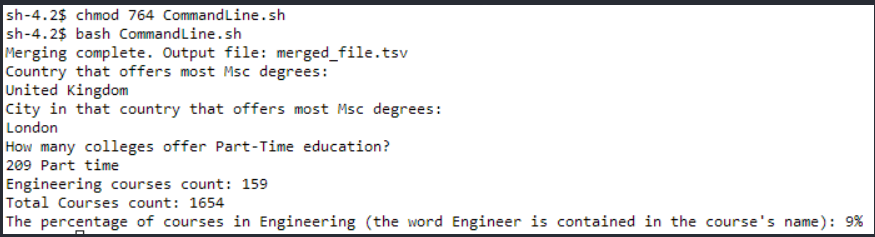

# Algorithmic Question

## 1. Code implementation

In [ ]:
def AQ_report(d, sumH, minTime, maxTime):
    # SUbtract the sum of the minimum hours for each day from the total hours
    sumH -= sum(minTime)
    
    # If the toal hours are < 0, it means that the required hours are more than 
    # the hours he worked and the report cannot be generated
    if sumH < 0:
        print('NO')
    else:
        # Iterate over the days
        for i in range(d):
            # 'Consume' all possible hours for the day updating the minimum hours 
            # until the maximum hours are reached or the total hours are 0
            while sumH > 0 and minTime[i] < maxTime[i]:
                # Increase the minimum hours for the day by 1
                minTime[i] += 1
                # Decrease the total hours by 1
                sumH -= 1

        if sumH == 0:
            print('YES')
            print(*minTime)
        else:
            print('NO')

### Example 1

In [50]:
d, S = map(int, input().split())
extr = [list(map(int, input().split())) for _ in range(d)]

In [51]:
AQ_report(d, S, [extr[i][0] for i in range(d)], [extr[i][1] for i in range(d)])

YES
1 4


### Example 2

In [52]:
d, S = map(int, input().split())
extr = [list(map(int, input().split())) for _ in range(d)]

In [53]:
AQ_report(d, S, [extr[i][0] for i in range(d)], [extr[i][1] for i in range(d)])

NO


## 2. Time complexity

The time complexity of the solution is $O(d)$, where $d$ is the number of days. 
The first subtraction requires constant time, however the sum of all the elements in the array is $O(d)$.
All the if statements are constant time so we can ignore them.
The main loop is $O(d)$ because it runs $d$ times. Inside it, there is a while loop that runs at most $(maxTime[i] - minTime[i])$ times for each day $i$. 

However, across all days, the inner loop can run only a total of $h$ times, where $h$ is the total number of hours Leonardo worked `sumH`.This is because we decrease $h$ by $1$ every time we go through the inner loop, and when $h$ reaches $0$ it stops. Thus, its time complexity is $O(h)$ and not $O(d*(maxTime[i] - minTime[i]))$.
From this we can conclude that the time complexity of the two nested loops is $O(d+h)$. More precisely, since $h$ does not depend on $d$, we can say that the time complexity of the two nested loops is dominated by the larger of $d$ and $h$, so it is $O(max(d, h))$.

Therefore the time complexity of the solution scales linearly with the number of days and we can say it is $O(n)$.

## 3. ChatGPT answer

Let's break down the time complexity of the provided code:

1. **Subtracting the Sum of Minimum Hours:**
   - The code subtracts the sum of minimum hours for each day from the total hours (`sumH -= sum(minTime)`).
   - Time Complexity: O(d), where 'd' is the number of days. This operation calculates the sum of minimum hours, which involves iterating through the list `minTime` containing 'd' elements.

2. **Iterating Over the Days:**
   - The code iterates over each day and incrementally increases the minimum hours for each day until the total hours are consumed or the maximum hours are reached.
   - In the worst case, it might iterate through each day ('d' iterations) and increment the minimum hours.
   - Time Complexity: O(d * max_hours), where 'max_hours' represents the maximum number of hours in a day. This complexity arises from the nested loops and depends on the maximum number of hours allowed per day.

Therefore, the overall time complexity of the code is O(d) + O(d * max_hours), which simplifies to O(d * max_hours). This time complexity arises from the initial calculation of the sum of minimum hours and the iterative process of increasing minimum hours for each day until the total hours are consumed or the maximum hours are reached.

ChatGPT doesn't take into acount the fact that the time complexity of the loop is actually limited by sumH. For this reason I don't think it is correct.

## 4. Optimality

The code uses a greedy approach. It iterates through each day and increases by $1$ the hours assigned to each day, starting from the minimum possible hours for each day, until the maximum is reached. This process continues until the total amount of hours is reached, and as stated above, the time complexity of this process is $O(max(d, h))$.

In order to solve the problem we need to look at least at each day once, which is $O(d)$, and then distribute the total amount of hours worked across the days. Therefore, any solution must have a time complexity of at least $O(d)$.

So, the provided solution is optimal in terms of time complexity since it is linear. 